### Fine-tuning hyperparameter
This notebook is to show a way of fune-tuning hyperparameter.
The dataset is from  [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit) and the data pre-processing can be found in [here](https://github.com/Canshuo/data-analysis-projects-with-python/blob/main/Give%20%20me%20some%20credit.ipynb).

Using the data to train a random forest, this notebook will display how to imporve model's performance by tuning the hyperparameter and how did I make it happen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [2]:
file = '/Users/canshuoguo/Downloads/GiveMeSomeCredit/Give_me_some_credit_training_data.csv'
training_set = pd.read_csv(file)
training_set = training_set.iloc[:,1:]
training_set

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
def data_process(df,is_submission=False):
    print('shape before:{}'.format(df.shape))
    df.loc[(df['age']<18) & (df['age']>96),'age'] = df['age'].median()
    
    df['DebtRatio'] = np.log(df['DebtRatio'])
    df["DebtRatio"].replace([np.inf, -np.inf], -10, inplace=True)
    
    if not is_submission:
        df = df[df["MonthlyIncome"] != 1]
    utilization_outlier = 8238
    if not is_submission:
        df = df[df['RevolvingUtilizationOfUnsecuredLines'] <= utilization_outlier]
    
    imputeDf = df[['age','NumberOfDependents','MonthlyIncome']].copy()
    imputeDf['seniority'] = pd.cut(imputeDf['age'],[0,35,60,np.inf],
                               labels=['junior','senior','mature'],include_lowest=True)
    income_dict = imputeDf.groupby('seniority')['MonthlyIncome'].median().to_dict()
    for label, median in income_dict.items():
        imputeDf['MonthlyIncome'] = np.where((imputeDf['MonthlyIncome'].isnull()) & (imputeDf['seniority'] ==label),
                                        int(median),imputeDf['MonthlyIncome'])
    df['MonthlyIncome'] = imputeDf["MonthlyIncome"]
    df['NumberOfDependents'].fillna(0, inplace=True)
    
    maximum_map = dict(zip(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate',
                            'NumberOfTime60-89DaysPastDueNotWorse'],
                          [13,17,11]))
    for column, value in maximum_map.items():
        df.loc[df[column]>=96,column] = maximum_map[column]
    print("Shape after: {}".format(df.shape))
    
    return df

In [4]:
train_data = data_process(training_set)

shape before:(150000, 11)
Shape after: (149372, 11)


/Library/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,1:],
                                train_data.iloc[:,0],random_state=42)

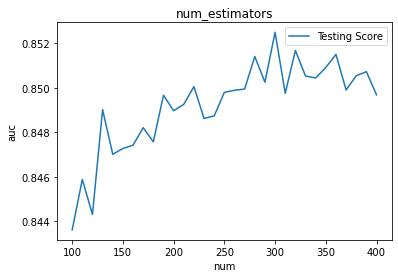

In [6]:
# begin fune-tuning the hyperparameter
## 'n_estimators'
num_estimators = range(100,401,10)
#train_scores = []
test_scores = []
for num_estimator in num_estimators:
    random_forest = RandomForestClassifier(n_estimators=num_estimator)
    random_forest.fit(X_train,y_train)
    pre_y1 = random_forest.predict_proba(X_train)[:,1]
    pre_y2 = random_forest.predict_proba(X_test)[:,1]
    #train_scores.append(roc_auc_score(train_y, pre_y1))
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(num_estimators,train_scores,label='Training Score')
ax.plot(num_estimators,test_scores,label='Testing Score')
ax.set_xlabel(r'num')
ax.set_ylabel(r'auc')
ax.set_title('num_estimators')
ax.legend(loc='best')
plt.show()

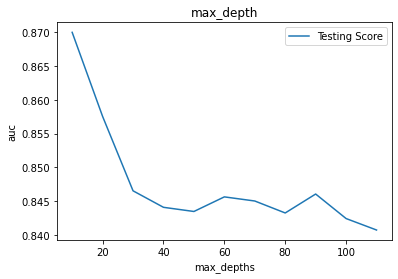

In [8]:
## 'max_depth'
max_depths = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depths.append(None)
test_scores = []
for max_depth in max_depths:
    random_forest = RandomForestClassifier(max_depth=max_depth)
    random_forest.fit(X_train,y_train)
    pre_y1 = random_forest.predict_proba(X_train)[:,1]
    pre_y2 = random_forest.predict_proba(X_test)[:,1]
    #train_scores.append(roc_auc_score(train_y, pre_y1))
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(num_estimators,train_scores,label='Training Score')
ax.plot(max_depths,test_scores,label='Testing Score')
ax.set_xlabel(r'max_depths')
ax.set_ylabel(r'auc')
ax.set_title('max_depth')
ax.legend(loc='best')
plt.show()

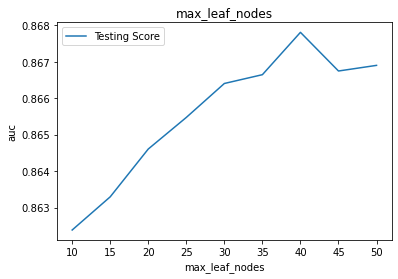

In [9]:
# 'max_leaf_nodes'
max_leaf_nodes = range(10,51,5)
test_scores = []
for max_leaf_node in max_leaf_nodes:
    random_forest = RandomForestClassifier(max_leaf_nodes=max_leaf_node)
    random_forest.fit(X_train,y_train)
    pre_y1 = random_forest.predict_proba(X_train)[:,1]
    pre_y2 = random_forest.predict_proba(X_test)[:,1]
    #train_scores.append(roc_auc_score(train_y, pre_y1))
    test_scores.append(roc_auc_score(y_test, pre_y2))

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(num_estimators,train_scores,label='Training Score')
ax.plot(max_leaf_nodes,test_scores,label='Testing Score')
ax.set_xlabel(r'max_leaf_nodes')
ax.set_ylabel(r'auc')
ax.set_title('max_leaf_nodes')
ax.legend(loc='best')
plt.show()

In [ ]:
## There is a easier way by using Grid Search or Random Search
### But it takes too much time to run through
from sklearn.model_selection import GridSearchCV
# Create the parameter grid
max_depths = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depths.append(None)

max_features = np.arange(1,11,1)
max_features = max_features/10.0

param_grid = {
    'bootstrap': [True],
    'max_depth': max_depths,
    'max_features': max_features,
    'max_leaf_nodes':range(10,51,5),
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': range(100,401,10)
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

In [11]:
from sklearn.model_selection import GridSearchCV
# I ran the code, but it was still running overnight, so I quit.
# since it's a demo, I just reduce the number of hyperparameter to save the time.

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
import time
time1 = time.time()
grid_search.fit(X_train,y_train)
print('running time:',time.time() - time1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
running time: 1407.4856131076813


In [21]:
second = 1407.4856131076813
m,s = divmod(second,60)
h,m = divmod(m,60)
print(f'running time:{h}h{m}m{round(s)}s')

running time:0.0h23.0m27s


### Evaluate the model 
- best_estimator_
    - Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data. 
- best_params_
    - Parameter setting that gave the best results on the hold out data.

In [16]:
grid_search.best_estimator_,grid_search.best_params_

(RandomForestClassifier(max_depth=100, max_features=2, n_estimators=200),
 {'bootstrap': True, 'max_depth': 100, 'max_features': 2, 'n_estimators': 200})

In [17]:
def plot_roc_curve(y_test,y_predcit):
    fpr,tpr,_ = roc_curve(y_test,y_predcit)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title('ROC curve')
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')

0.8507803681642904


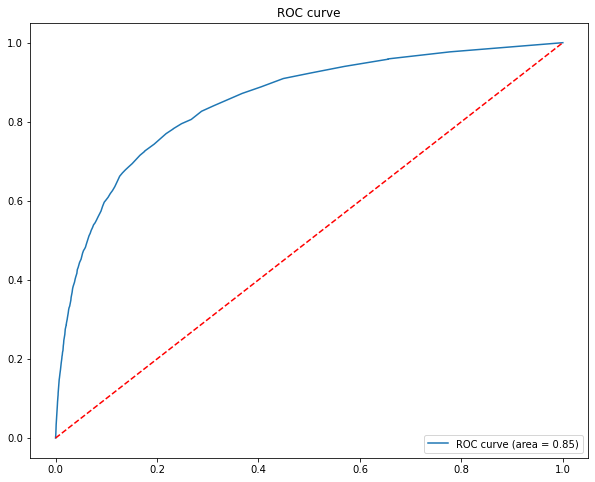

In [18]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train,y_train)
y_pred_rf = best_grid.predict_proba(X_test)[:,1]
plot_roc_curve(y_test,y_pred_rf)